In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

In [6]:
#首先获取图片,glob这个库明显感觉更加好用
train_image_path=glob.glob('F://UNIVERSITY STUDY/AI/dataset/catdog/train/*/*.jpg')
#加上*号是为了将当前目录下的所有文件，再加上一个星号是为了提取当前目录下的所有jpg文件

In [8]:
train_image_path[:5]

['F://UNIVERSITY STUDY/AI/dataset/catdog/train\\cat\\cat.0.jpg',
 'F://UNIVERSITY STUDY/AI/dataset/catdog/train\\cat\\cat.1.jpg',
 'F://UNIVERSITY STUDY/AI/dataset/catdog/train\\cat\\cat.10.jpg',
 'F://UNIVERSITY STUDY/AI/dataset/catdog/train\\cat\\cat.100.jpg',
 'F://UNIVERSITY STUDY/AI/dataset/catdog/train\\cat\\cat.101.jpg']

In [9]:
len(train_image_path)

2000

In [12]:
#现在提取label，我们只需要0/1来判断是猫还是狗，就是使用的python当中的最基础的知识
#开始小实验
p='F://UNIVERSITY STUDY/AI/dataset/catdog/train\\cat\\cat.0.jpg'
p.split("\\")

['F://UNIVERSITY STUDY/AI/dataset/catdog/train', 'cat', 'cat.0.jpg']

In [13]:
int(p.split("\\")[1]=='cat')#利用这种方法输出1还是0

1

In [14]:
train_image_label=[int(p.split("\\")[1]=='cat') for p in train_image_path ]
#经过一个列表推倒式就可以得到所有label

In [18]:
train_image_label[-5:]#秒啊！

[0, 0, 0, 0, 0]

In [61]:
#现在我们的jpg文件进行解码，变成三维矩阵
def load_preprosess_image(path,label):
    #读取路径
    image=tf.io.read_file(path)
    #解码
    image=tf.image.decode_jpeg(image,channels=3)#彩色图像为3个channel
    #将图像改变为同样的大小，利用裁剪或者扭曲,这里应用了扭曲
    image=tf.image.resize(image,[360,360])
    #随机裁剪图像
    image=tf.image.random_crop(image,[256,256,3])
    #随机上下翻转图像
    image=tf.image.random_flip_left_right(image)
    #随机上下翻转
    image=tf.image.random_flip_up_down(image)
    #随机改变图像的亮度
    image=tf.image.random_brightness(image,0.5)
    #随机改变对比度
    image=tf.image.random_contrast(image,0,1)
    #改变数据类型
    image=tf.cast(image,tf.float32)
    #将图像进行归一化
    image=image/255
    #现在还需要对label进行处理，我们现在是列表[1,2,3],
    #需要变成[[1].[2].[3]]
    label=tf.reshape(label,[1])
    return image,label

In [62]:
#现在开始创建dataset
train_image_ds=tf.data.Dataset.from_tensor_slices((train_image_path,train_image_label))
#居然可以两个继续联合引入？那么之后怎么用自定义的函数对其进行处理呢？

In [63]:
AUTOTUNE=tf.data.experimental.AUTOTUNE#根据计算机性能进行运算速度的调整

In [64]:
train_image_ds=train_image_ds.map(load_preprosess_image,num_parallel_calls=AUTOTUNE)
#后面的参数表示处理并行运算的CPU运行数量
train_image_ds

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

In [65]:
#现在train_image_ds就读取进来了，现在进行乱序和batchsize的规定
BATCH_SIZE=32
train_count=len(train_image_path)
#现在设置batch和乱序
train_image_ds=train_image_ds.shuffle(train_count).batch(BATCH_SIZE)
train_image_ds=train_image_ds.prefetch(AUTOTUNE)#预处理一部分处理，准备读取

In [66]:
imags,labels=iter(train_image_ds).next()#放到生成器里，单独取出数据

In [67]:
imags.shape

TensorShape([32, 256, 256, 3])

In [68]:
labels.shape

TensorShape([32, 1])

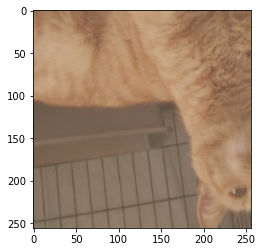

In [72]:
plt.imshow(imags[25])

In [73]:
#现在开始创建模型
model=keras.Sequential([
tf.keras.layers.Conv2D(64,(3,3),input_shape=(256,256,3),activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(256,activation='relu'),
tf.keras.layers.Dense(1)
])

In [74]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 512)       590336    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [75]:
#使用更加繁琐的自定义训练，也可以的.既能够自定义，也可以模型帮助我们进行定义
loss=tf.keras.losses.BinaryCrossentropy()#用这个来计算交叉熵

In [76]:
#定义优化器
optimizer=tf.keras.optimizers.Adam()

In [77]:
epoch_loss_avg=tf.keras.metrics.Mean('train_loss')#定义平均损失
train_accuracy=tf.keras.metrics.Accuracy()

In [78]:
def train_step(model,image,labels):
    with tf.GradientTape() as t:
        pred=model(image)
        #计算损失,比较标签值和预测值的区别
        loss_step=tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels,pred)
    grads=t.gradient(loss_step,model.trainable_variables)#计算梯度
    optimizer.apply_gradients(zip(grads,model.trainable_variables))#根据梯度进行优化
    epoch_loss_avg(loss_step)
    train_accuracy(labels,tf.cast(pred>0,tf.int32))

In [79]:
train_loss_results=[]
train_acc_resuls=[]

In [80]:
num_epochs=30
for epoch in range(num_epochs):
    for imgs_,labels_ in train_image_ds:
        train_step(model,imgs_,labels_)
        print('.',end=' ')#每一个batch就打印一个点
    print()#换行
    #还可以把train——loss拿进来
    train_loss_results.append(epoch_loss_avg.result())
    train_acc_resuls.append(train_accuracy)
    
    print('Epoch :{}.loss: {:.3f},acc:{:.3f}'.format(epoch+1,epoch_loss_avg.result(),train_accuracy.result()))
    
    epoch_loss_avg.reset_states()#重置目前的loss，这样就可以只用到了目前的平均loss
    train_accuracy.reset_states()

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch :1.loss: 0.695,acc:0.491
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch :2.loss: 0.693,acc:0.500
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch :3.loss: 0.693,acc:0.492
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch :4.loss: 0.693,acc:0.482
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Epoch :5.loss: 0.694,acc:0.499
. . . . . . . . . . . 

KeyboardInterrupt: 